# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

In [2]:
from statsmodels.regression.linear_model import yule_walker

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
import numpy as np
import pandas as pd

In [5]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [6]:
import random

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")

In [45]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
from feature_engine.selection import DropCorrelatedFeatures

In [74]:
!pip install feature_engine

In [11]:
from matplotlib.patches import Patch

# Download the dataset and check the data structure

In [12]:
data = loadmat("S1_E1_A1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


Now, load in the EMG data. Check the data structure printing data dimension and type.

In [13]:
emg_data = data["emg"]
print("EMG data dimension: {}".format(emg_data.shape))
print("EMG data type: {}".format(type(emg_data)))

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>


Load in hand kinematics labels. Select only the joint angles associated to the joint angles of interest (3,6,8,11,14 see the glove image here https://ninapro.hevs.ch/instructions/DB8.html). Take only the part of data labels where index finger is involved in movement (see cell above). Check the data structure printing data dimension and type.

In [14]:
# Only regressing on finger joint 3,6,8,11,14
glove_data_index = data["glove"][:, [2,5,7,10,13]]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


In [15]:
stimulus = data['restimulus']
repetition = data['rerepetition']
# For each different stimulus, take the datapoints where that stimulus is active
for stimulus_value in np.unique(stimulus):
    unique_stimulus = stimulus_value
    indices = np.where(stimulus == unique_stimulus)[0]
    # Separate the indices into contiguous segments
    s = np.split(indices, np.where(np.diff(indices) != 1)[0]+1)
    # For each contiguous segment, print the start and end indices
    for segment in s:
        start_idx = segment[0]
        end_idx = segment[-1]
        print(f"Stimulus {unique_stimulus}: Start index: {start_idx}, End index: {end_idx}")

Stimulus 0: Start index: 0, End index: 19893
Stimulus 0: Start index: 28440, End index: 41556
Stimulus 0: Start index: 50018, End index: 63754
Stimulus 0: Start index: 74352, End index: 85626
Stimulus 0: Start index: 93778, End index: 107525
Stimulus 0: Start index: 116170, End index: 129578
Stimulus 0: Start index: 137831, End index: 152056
Stimulus 0: Start index: 160578, End index: 173689
Stimulus 0: Start index: 181988, End index: 196512
Stimulus 0: Start index: 203940, End index: 219337
Stimulus 0: Start index: 225005, End index: 246792
Stimulus 0: Start index: 255908, End index: 268707
Stimulus 0: Start index: 278123, End index: 291175
Stimulus 0: Start index: 299213, End index: 314114
Stimulus 0: Start index: 322563, End index: 336733
Stimulus 0: Start index: 345594, End index: 358217
Stimulus 0: Start index: 369162, End index: 380878
Stimulus 0: Start index: 389867, End index: 402923
Stimulus 0: Start index: 416007, End index: 424823
Stimulus 0: Start index: 433192, End index: 

# Input data visualisation and preprocessing

Number of channels in the EMG data: 16


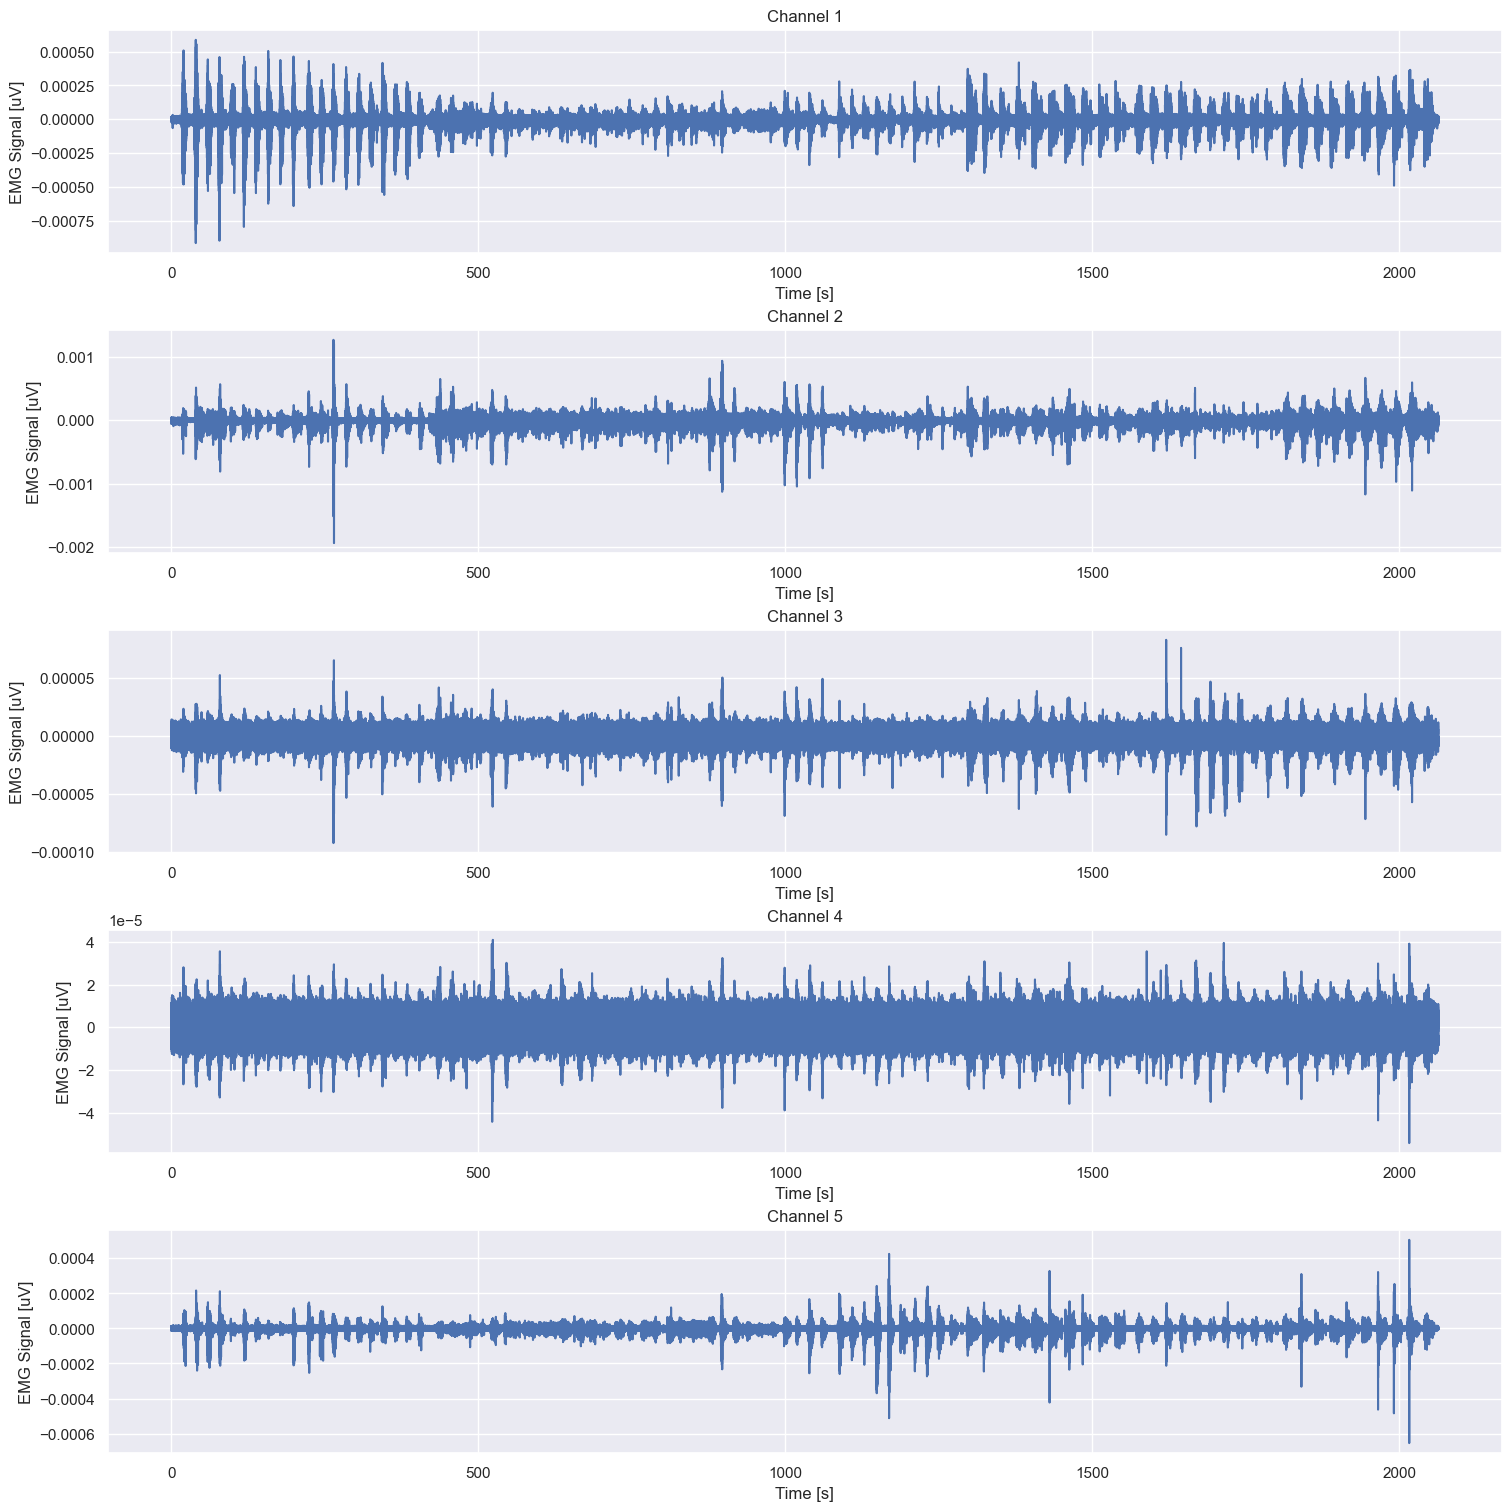

In [16]:
fs = 1111  # [Hz], from dataset description
n_channels = emg_data.shape[1]
print(f"Number of channels in the EMG data: {n_channels}")
time_steps = np.arange(emg_data.shape[0]) / fs
fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for i in range(5):
    ax[i].plot(time_steps, emg_data[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"Channel {i+1}")

We can see when the channel is picking up signals from the muscles. Let's check the signal quality to decide on the signal processing techniques.

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

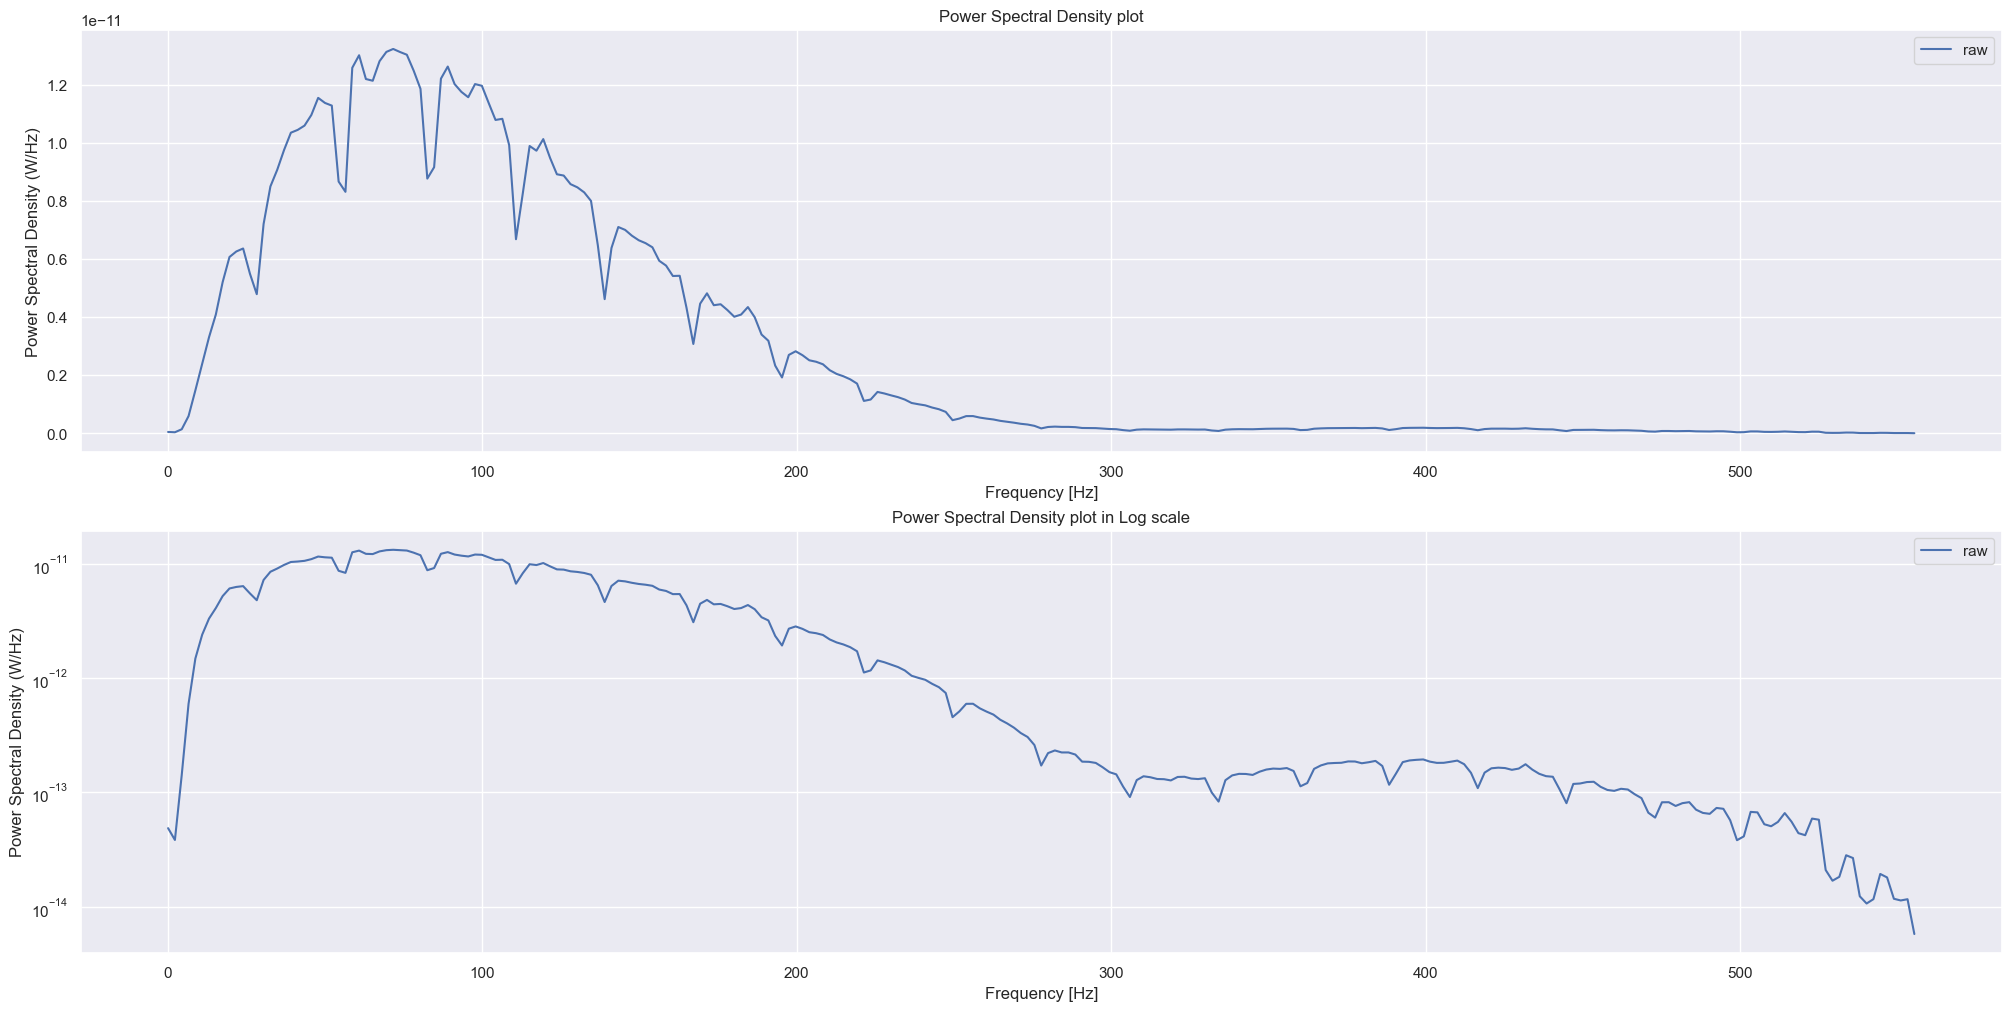

In [17]:
# We use Welch's method for power spectral density estimation (reduces the variance of the estimate)
freqs_pre, Pxx_pre = welch(emg_data[:, 5], fs=fs, nperseg=512)

fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(20, 10))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

It looks like most of the harmonic frequencies of powerline noise have already been removed using a bandstop filer and that there is not much happening outside of the frequency range 0-500. So I think that the preprocessing is unuseful. 

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

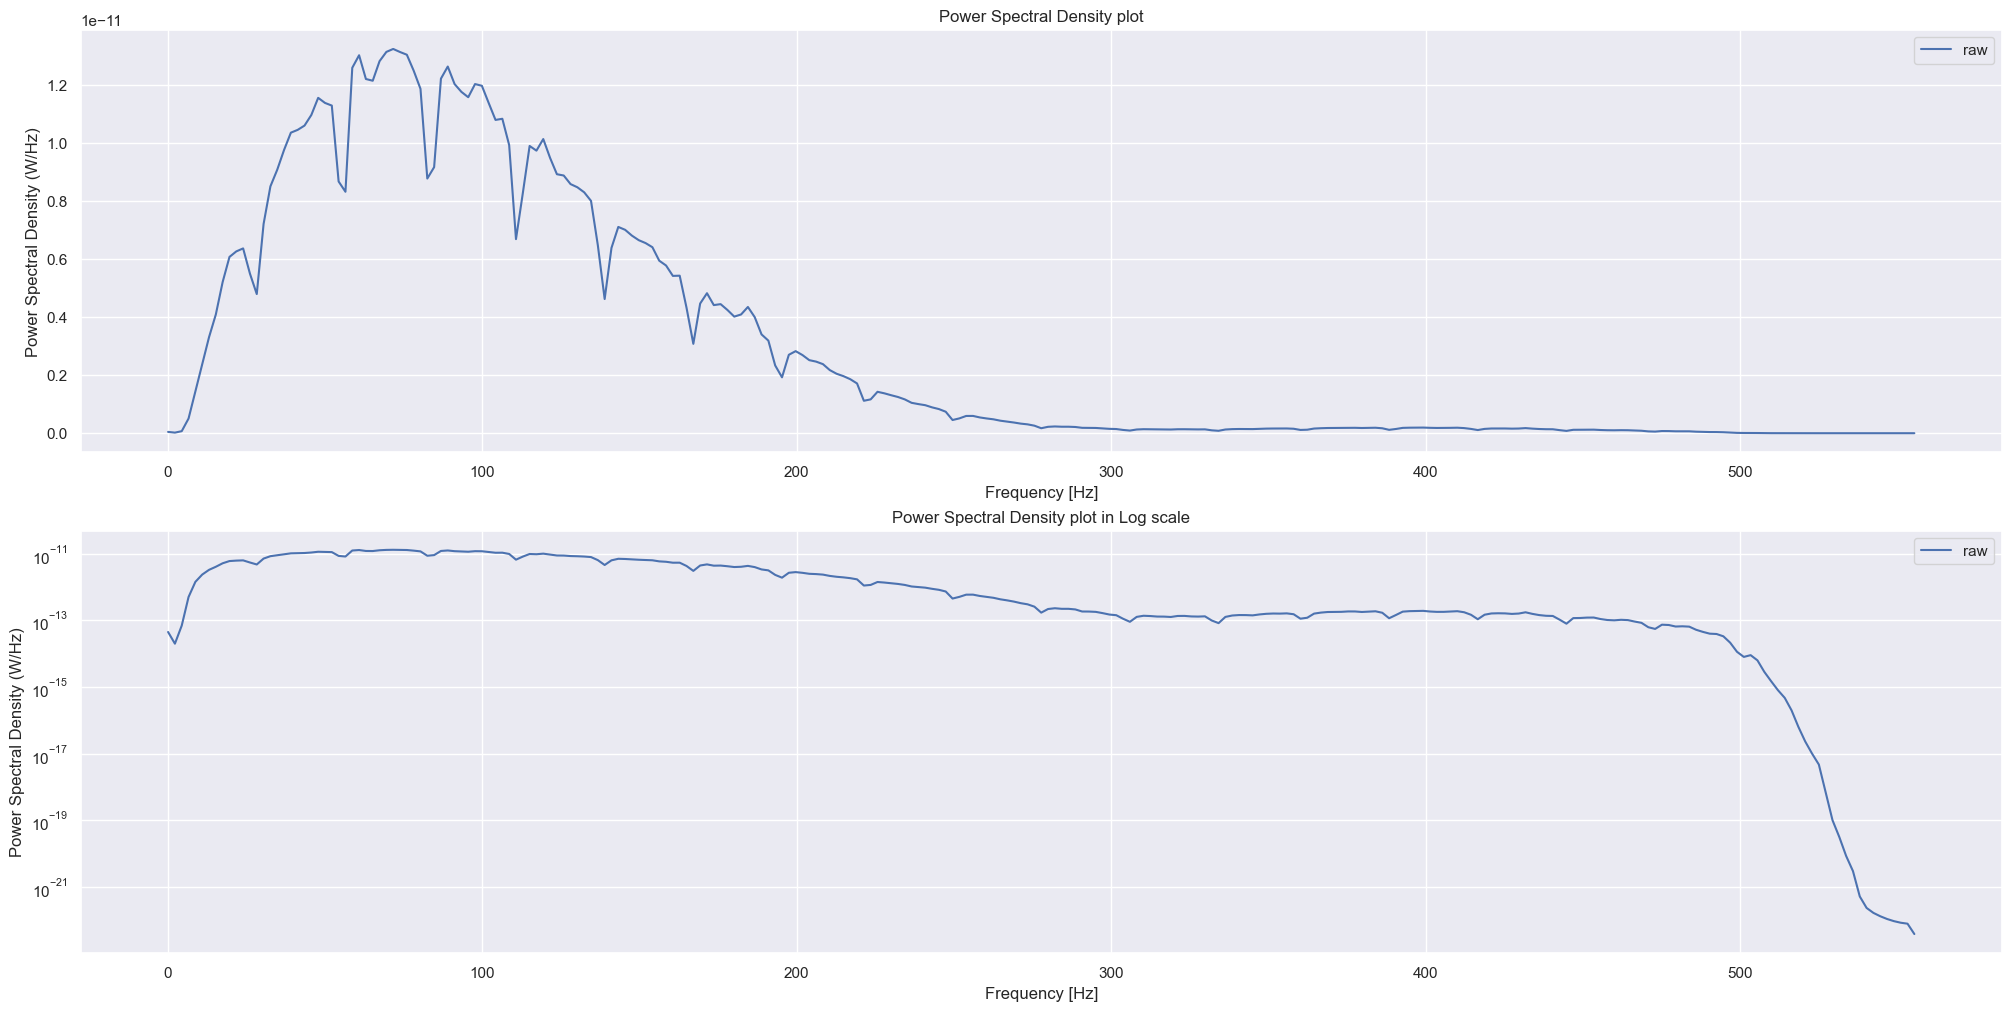

In [18]:
# Applying a bandpass butterworth filter and check power spectra density

bandpass_cutoff=(5,500)
sos = butter(N=4, Wn=bandpass_cutoff, fs=fs, btype="bandpass", output="sos")
emg_bandpassed = sosfiltfilt(sos, emg_data.T).T

freqs_pre, Pxx_pre = welch(emg_bandpassed[:, 5], fs=fs, nperseg=512)

fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(20, 10))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

But the signal still needs to be rectified:

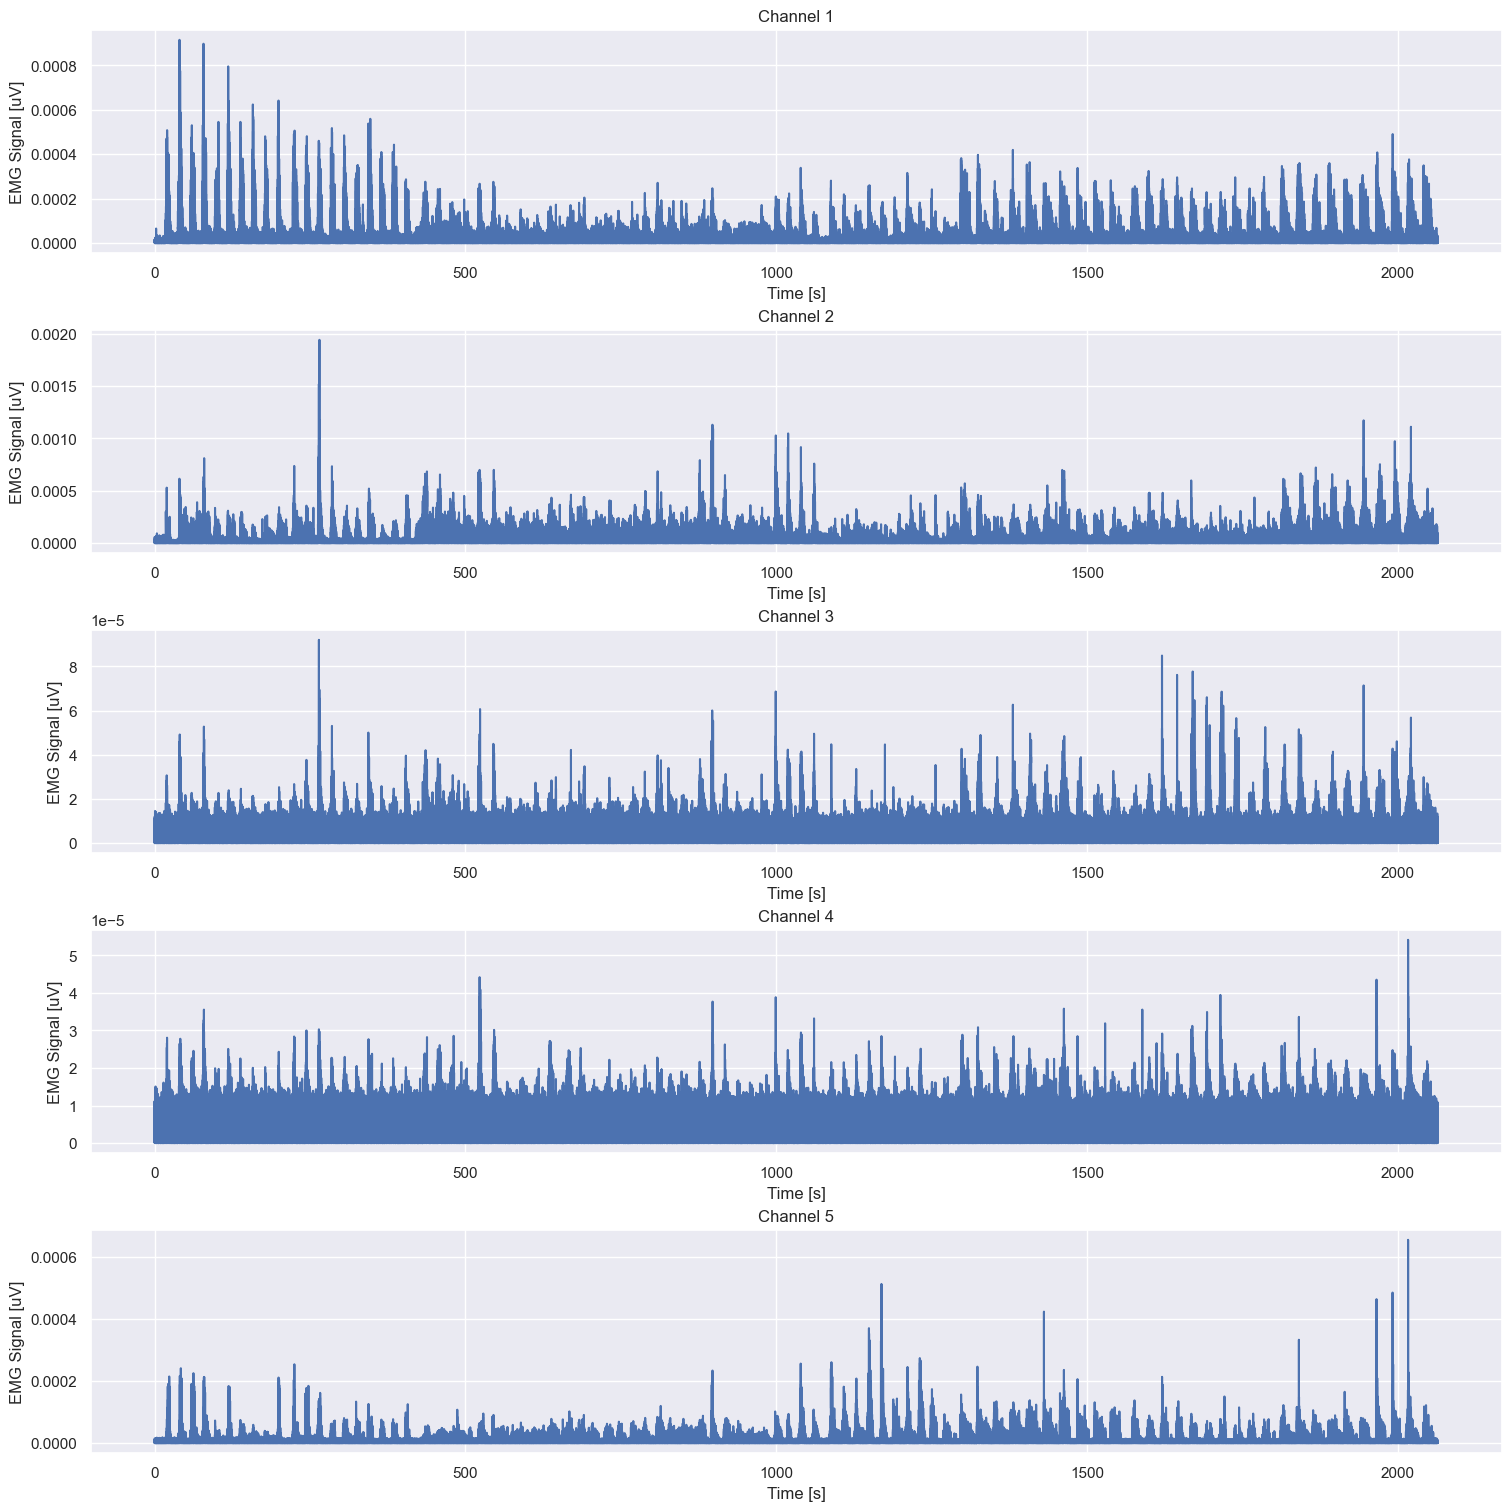

In [19]:
# Rectify signals
emg_rectified = np.abs(emg_data) # Rectify the signal

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for i in range(5):
    ax[i].plot(time_steps, emg_rectified[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"Channel {i+1}")

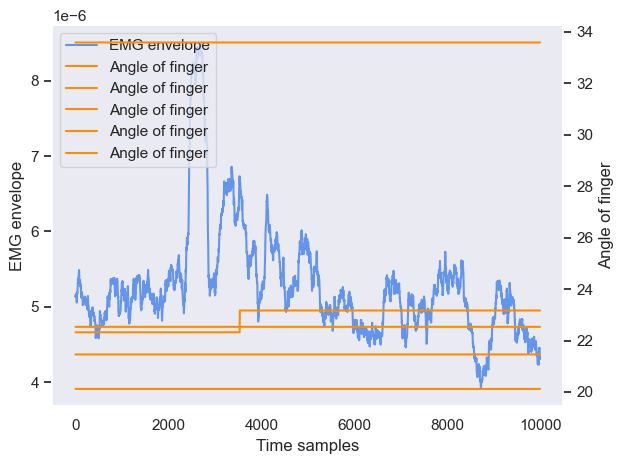

In [20]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:10000, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data_index[:10000, :], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

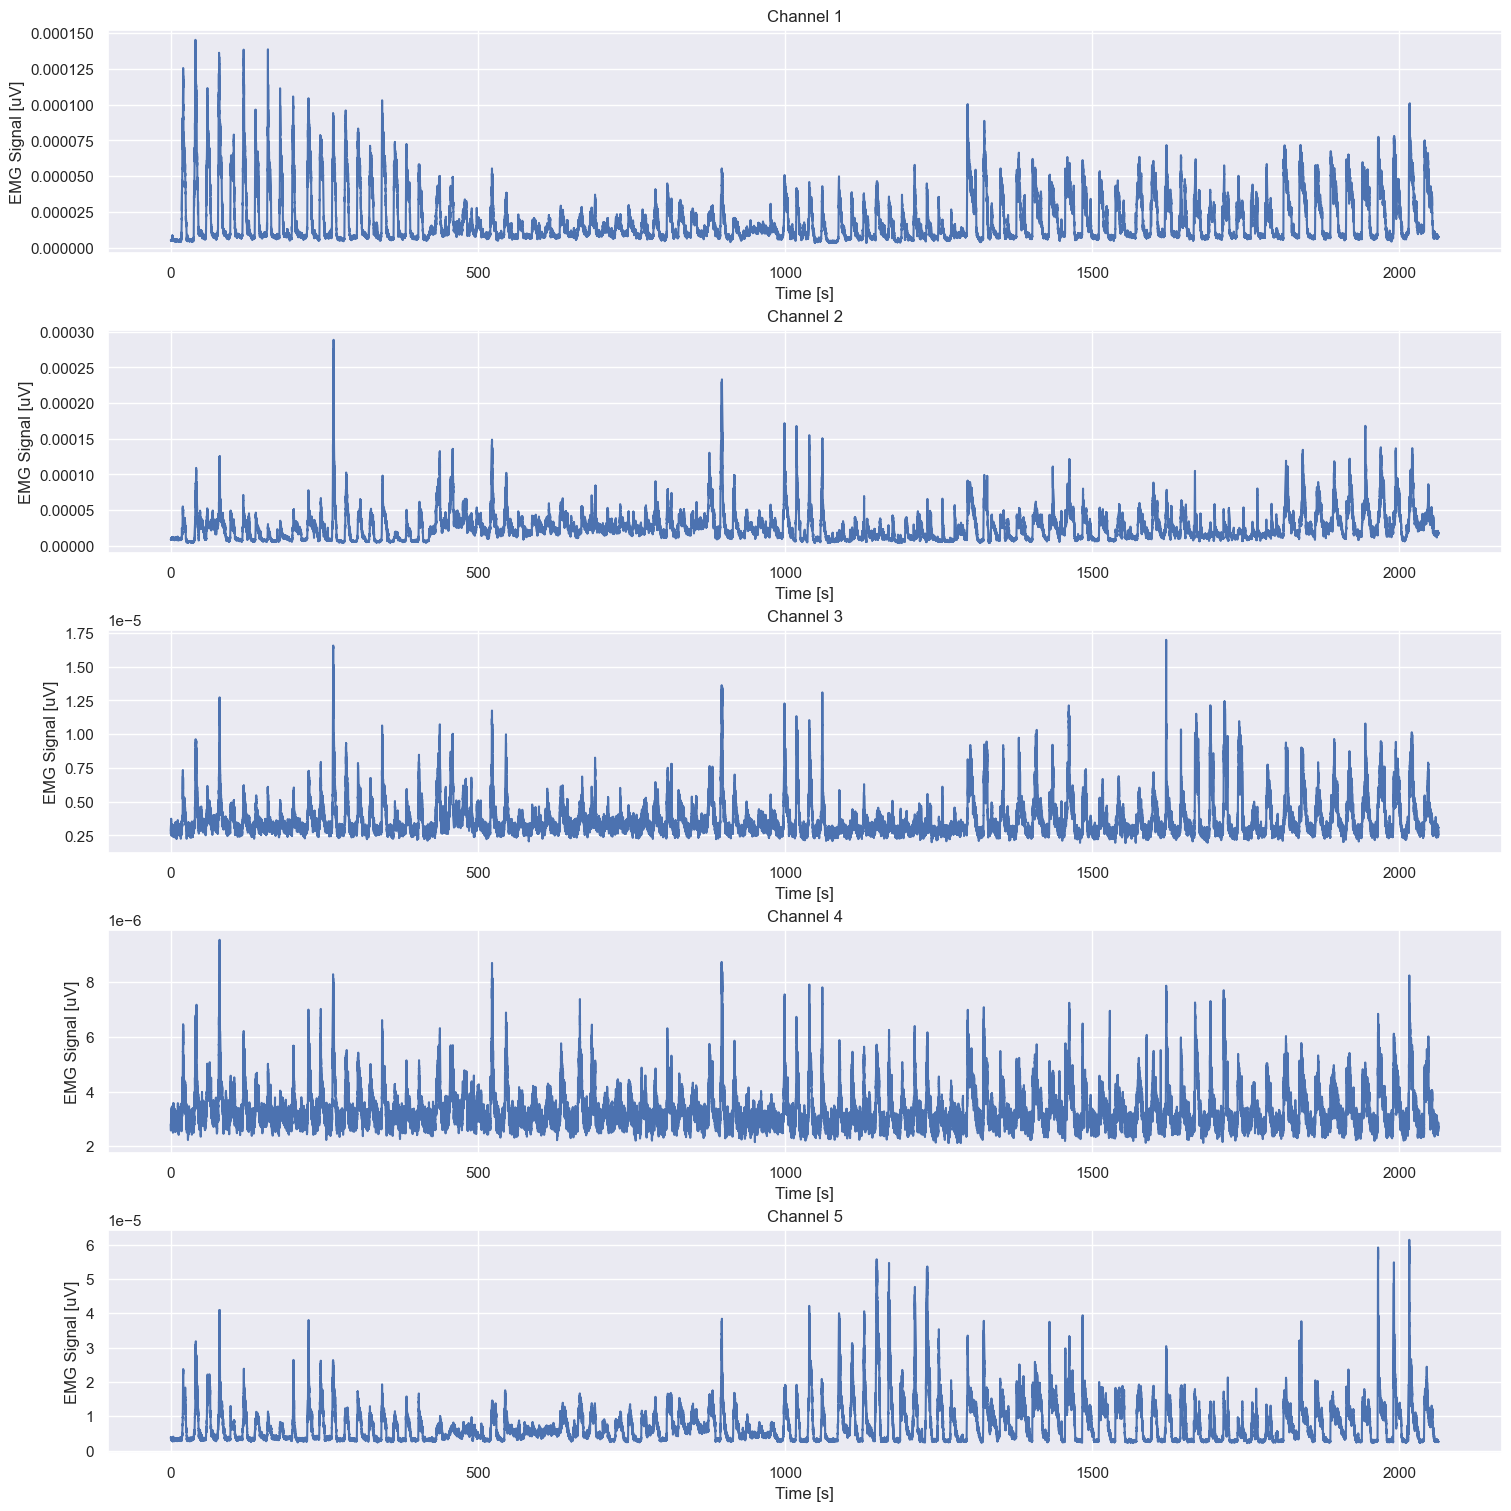

In [21]:
# Rectify signals
emg_rectified = np.abs(emg_data) # Rectify the signal

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for i in range(5):
    ax[i].plot(time_steps, EMG_envelopes[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"Channel {i+1}")

Before going to do sliding windows, let's do the train-val-test split

# Train-val-test split

In [22]:
# Divide the dataset into three parts, so that the val set is all the repetions number 2 and 7 and the test set is all the repetions number 5
stimulus = data['restimulus']
repetition = data['rerepetition']
train_indices = np.where((repetition != 2) & (repetition != 5) & (repetition != 7))[0]
val_indices = np.where((repetition == 2) | (repetition == 7))[0]
test_indices = np.where(repetition == 5)[0]

# get train, val, test
# IMPORTANT: we do this before 1D convolution (moving average) to get EMG envelop so that there is no train-test leakage.
EMG_train = emg_rectified[train_indices]
Labels_train = glove_data_index[train_indices]
EMG_val = emg_rectified[val_indices]
Labels_val = glove_data_index[val_indices]
EMG_test = emg_rectified[test_indices]
Labels_test = glove_data_index[test_indices]

# get EMG envelope on train, val, test set individually
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_train = convolve1d(EMG_train, weights=mov_mean_weights, axis=0)
EMG_val = convolve1d(EMG_val, weights=mov_mean_weights, axis=0)
EMG_test = convolve1d(EMG_test, weights=mov_mean_weights, axis=0)

# Print the shapes of the resulting datasets
print("Training set EMG shape:", EMG_train.shape)
print("Training set Labels shape:", Labels_train.shape)
print("Validation set EMG shape:", EMG_val.shape)
print("Validation set Labels shape:", Labels_val.shape)
print("Test set EMG shape:", EMG_test.shape)
print("Test set Labels shape:", Labels_test.shape) 

Training set EMG shape: (1648512, 16)
Training set Labels shape: (1648512, 5)
Validation set EMG shape: (428749, 16)
Validation set Labels shape: (428749, 5)
Test set EMG shape: (215265, 16)
Test set Labels shape: (215265, 5)


# Sliding windows split

To process the dataset efficiently, we divide it into overlapping sliding windows. This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments, while maintaining continuity through overlapping segments.

In [23]:
fs = 1111  # [Hz], from dataset description
emg_window_length_sec = 128e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

print(int(emg_window_length_sec*fs))
print(int(incremental_window_length_sec*fs))

142
55


In [24]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [25]:
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows_train, Labels_windows_train = extract_time_windows_regression(EMG_train, Labels_train, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_val, Labels_windows_val = extract_time_windows_regression(EMG_val, Labels_val, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_test, Labels_windows_test = extract_time_windows_regression(EMG_test, Labels_test, fs, emg_window_length_sec, incremental_window_length_sec)


print(f"EMG train data shape: {EMG_windows_train.shape}, Train label shape: {Labels_windows_train.shape}")
print(f"EMG validation data shape: {EMG_windows_val.shape}, Validation label shape: {Labels_windows_val.shape}")
print(f"EMG test data shape: {EMG_windows_test.shape}, Test label shape: {Labels_windows_test.shape}")

EMG train data shape: (29971, 142, 16), Train label shape: (29971, 142, 5)
EMG validation data shape: (7793, 142, 16), Validation label shape: (7793, 142, 5)
EMG test data shape: (3912, 142, 16), Test label shape: (3912, 142, 5)


# Feature extraction for regressor

Now that we have the windows, lets extract some features again. For this exercise, we will just look at the simple features: mean, std and max amplitude of the windows.

In [26]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: numpy arrays for extracted features, labels and corresponding feature names
    """
    
    # EMG_windows is of shape (#samples, #time-points in a single window, #channels)
    # Parameters
    wa_threshold = 0.01
    ssc_threshold = 0.01
    ar_order = 4
    
    # 1. Mean
    mean_feature = np.mean(EMG_windows, axis=1)  # (20000, 16)
    
    # 2. Std 
    std_feature = np.std(EMG_windows, axis=1)
    
    # 3. Max Amplitude 
    max_feature = np.max(np.abs(EMG_windows), axis=1)
    
    # 4. Wilson Amplitude 
    wa_feature = np.sum(np.abs(np.diff(EMG_windows, axis=1)) > wa_threshold, axis=1)
    
    # 5. Waveform Length
    wl_feature = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    
    # 6. Log-Variance 
    logvar_feature = np.log(np.var(EMG_windows, axis=1) + 1e-10)  # stability
    
    # 7. Slope Sign Change 
    x_prev = EMG_windows[:, :-2, :]
    x_curr = EMG_windows[:, 1:-1, :]
    x_next = EMG_windows[:, 2:, :]
    ssc_feature = np.sum(((x_curr - x_prev) * (x_curr - x_next)) > ssc_threshold, axis=1)
    
    # 8. 4th-Order Auto-Regressive Coefficients
    # Initialize array (samples, channels, 4)
    ar_feature = np.zeros((EMG_windows.shape[0], EMG_windows.shape[2], ar_order))
    
    # Compute AR coefficients per window per channel
    for ch in range(EMG_windows.shape[2]):
        for w in range(EMG_windows.shape[0]):
            rho, sigma = yule_walker(EMG_windows[w, :, ch], order=ar_order)
            ar_feature[w, ch, :] = rho
    
    # Flatten AR coefficients to concatenate
    ar_feature_flat = ar_feature.reshape(EMG_windows.shape[0], -1)  # (samples, channels*4=64)
    
    # Concatenate all features
    features = np.concatenate([
        mean_feature, std_feature, max_feature, wa_feature,
        wl_feature, logvar_feature, ssc_feature, ar_feature_flat
    ], axis=1)

    # Get ground truth labels by calculating mean over the windows
    Labels_mean = np.mean(Labels_windows,axis=1)


    #Generate feature names
    feature_names = []
    num_channels = 16

    # Single-channel features
    base_names = ["mean", "std", "max", "wa", "wl", "logvar", "ssc"]
    for name in base_names:
        for ch in range(1, num_channels + 1):
            feature_names.append(f"{name}_{ch}")

    # AR features: ar1_channel, ar2_channel, ar3_channel, ar4_channel
    for ch in range(1, num_channels + 1):
        for order in range(1, ar_order + 1):
            feature_names.append(f"ar{order}_{ch}")

    # return features and labels for ML model
    return features, Labels_mean, feature_names


In [27]:
EMG_train_extracted_features, Labels_train_mean, feature_names = extract_features(EMG_windows_train,Labels_windows_train)
EMG_val_extracted_features, Labels_val_mean,_ = extract_features(EMG_windows_val,Labels_windows_val)
EMG_test_extracted_features, Labels_test_mean,_ = extract_features(EMG_windows_test,Labels_windows_test)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG val extracted features shape: {}, Finger labels feature shape:{}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (29971, 176), Finger labels feature shape:(29971, 5)
EMG val extracted features shape: (7793, 176), Finger labels feature shape:(7793, 5)
EMG test extracted features shape: (3912, 176), Finger labels feature shape:(3912, 5)


Total features: 7 + 4 (AR) = 11. <br>
We have a total of 176 features -> 16 channels * 11 features for each channel.

In [28]:
# Normalize the features
scaler = StandardScaler()
scaler.fit(EMG_train_extracted_features) #use mean and std from the train set
EMG_train_scaled = scaler.transform(EMG_train_extracted_features)
EMG_val_scaled = scaler.transform(EMG_val_extracted_features)
EMG_test_scaled = scaler.transform(EMG_test_extracted_features)

# Convert to DataFrame for convenience
df_train = pd.DataFrame(EMG_train_scaled, columns=feature_names)

df=df_train
# Check which features have NaNs
nan_features = df.columns[df.isna().any()].tolist()
print("Features with NaNs:", nan_features)

# Check which features are constant (zero variance)
constant_features = df.columns[df.nunique() <= 1].tolist()
print("Constant features:", constant_features)

# Optional: check for infinite values
inf_features = df.columns[(df == np.inf).any() | (df == -np.inf).any()].tolist()
print("Features with infinities:", inf_features)


Features with NaNs: []
Constant features: ['wa_1', 'wa_2', 'wa_3', 'wa_4', 'wa_5', 'wa_6', 'wa_7', 'wa_8', 'wa_9', 'wa_10', 'wa_11', 'wa_12', 'wa_13', 'wa_14', 'wa_15', 'wa_16', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7', 'ssc_8', 'ssc_9', 'ssc_10', 'ssc_11', 'ssc_12', 'ssc_13', 'ssc_14', 'ssc_15', 'ssc_16']
Features with infinities: []


In [29]:
# val and test dataframes
df_train = pd.DataFrame(EMG_train_scaled, columns=feature_names)
df_val = pd.DataFrame(EMG_val_scaled, columns=feature_names)
df_test = pd.DataFrame(EMG_test_scaled, columns=feature_names)

# Check which features are constant (zero variance)
constant_features = df_train.columns[df_train.nunique() <= 1].tolist()
print("Constant features:", constant_features)

# drop constant features
df_train = df_train.drop(columns=constant_features)
df_val = df_val.drop(columns=constant_features)
df_test = df_test.drop(columns=constant_features)


Constant features: ['wa_1', 'wa_2', 'wa_3', 'wa_4', 'wa_5', 'wa_6', 'wa_7', 'wa_8', 'wa_9', 'wa_10', 'wa_11', 'wa_12', 'wa_13', 'wa_14', 'wa_15', 'wa_16', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7', 'ssc_8', 'ssc_9', 'ssc_10', 'ssc_11', 'ssc_12', 'ssc_13', 'ssc_14', 'ssc_15', 'ssc_16']


In [30]:
df_train.shape, df_val.shape, df_test.shape

((29971, 144), (7793, 144), (3912, 144))

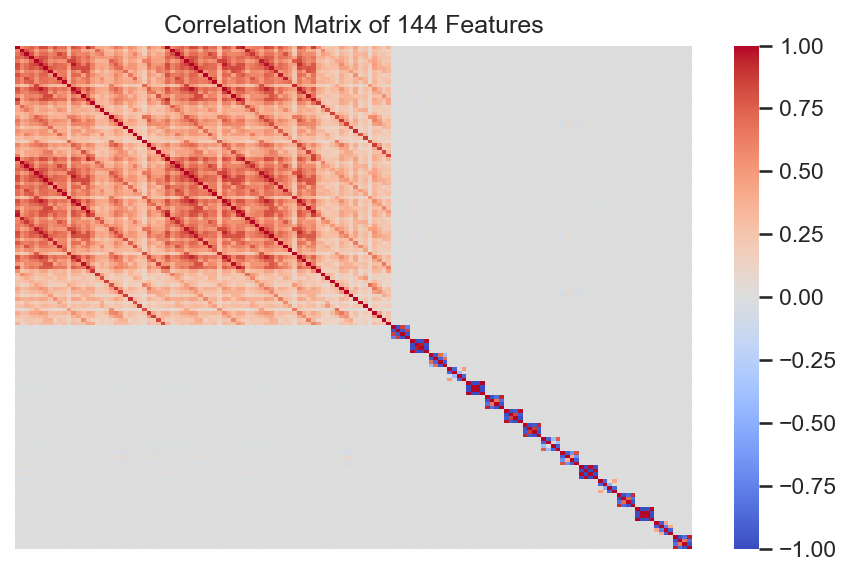

In [31]:
# Compute correlation matrix
corr_matrix = df_train.corr()

plt.figure(figsize=(6, 4), dpi=150)  # large figure and high resolution
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    xticklabels=False,  # hide x labels
    yticklabels=False,  # hide y labels
    linewidths=0,       # remove gaps
    linecolor=None       # no lines
)

plt.title("Correlation Matrix of 144 Features", fontsize=12)
plt.tight_layout()
plt.show()

In [32]:
# Drop the features (1 from the pair) that are highly correlated (>0.90 or <-0.90)
# Linear models (like regression) are sensitive to multicollinearity, but nonlinear models like random forests, XGBoost, SVM, or neural networks can leverage all correlated features effectively.
# So only remove very highly correlated features, not just features that are a little correlated. Because in time-series, AR is inherently correlated for a channel, but still contains unique info.

selector = DropCorrelatedFeatures(threshold=0.90).fit(df_train) # absolute threshold

df_train_new = selector.transform(df_train)
df_val_new   = selector.transform(df_val)
df_test_new  = selector.transform(df_test)

print(selector.correlated_feature_sets_)

[{'ar1_1', 'ar2_1'}, {'ar1_10', 'ar2_10'}, {'ar3_11', 'ar2_11', 'ar1_11', 'ar4_11'}, {'ar2_13', 'ar4_13', 'ar1_13'}, {'ar2_14', 'ar3_14', 'ar1_14', 'ar4_14'}, {'ar1_15', 'ar2_15'}, {'ar4_16', 'ar1_16', 'ar2_16'}, {'ar1_2', 'ar4_2', 'ar3_2', 'ar2_2'}, {'ar2_3', 'ar1_3'}, {'ar3_5', 'ar2_5', 'ar4_5', 'ar1_5'}, {'ar1_6', 'ar2_6', 'ar4_6'}, {'ar1_7', 'ar2_7', 'ar4_7', 'ar3_7'}, {'ar2_8', 'ar3_8', 'ar4_8', 'ar1_8'}, {'ar1_9', 'ar2_9'}, {'ar3_1', 'ar4_1'}, {'ar3_10', 'ar4_10'}, {'ar4_15', 'ar3_15'}, {'ar3_3', 'ar4_3'}, {'ar3_9', 'ar4_9'}, {'std_2', 'logvar_2'}, {'logvar_9', 'std_9'}, {'max_1', 'mean_16', 'wl_1', 'mean_1', 'max_16'}, {'max_10', 'wl_10', 'mean_10'}, {'max_11', 'mean_11'}, {'max_12', 'wl_12', 'mean_12'}, {'max_6', 'wl_13', 'mean_13', 'max_13', 'wl_6', 'mean_6'}, {'max_14', 'wl_14', 'mean_14'}, {'mean_15', 'wl_15', 'max_15'}, {'max_2', 'mean_2', 'wl_2'}, {'max_3', 'wl_3', 'mean_3'}, {'mean_4', 'max_4'}, {'mean_5', 'wl_5', 'max_5'}, {'max_7', 'mean_7', 'wl_7'}, {'mean_8', 'max_8',

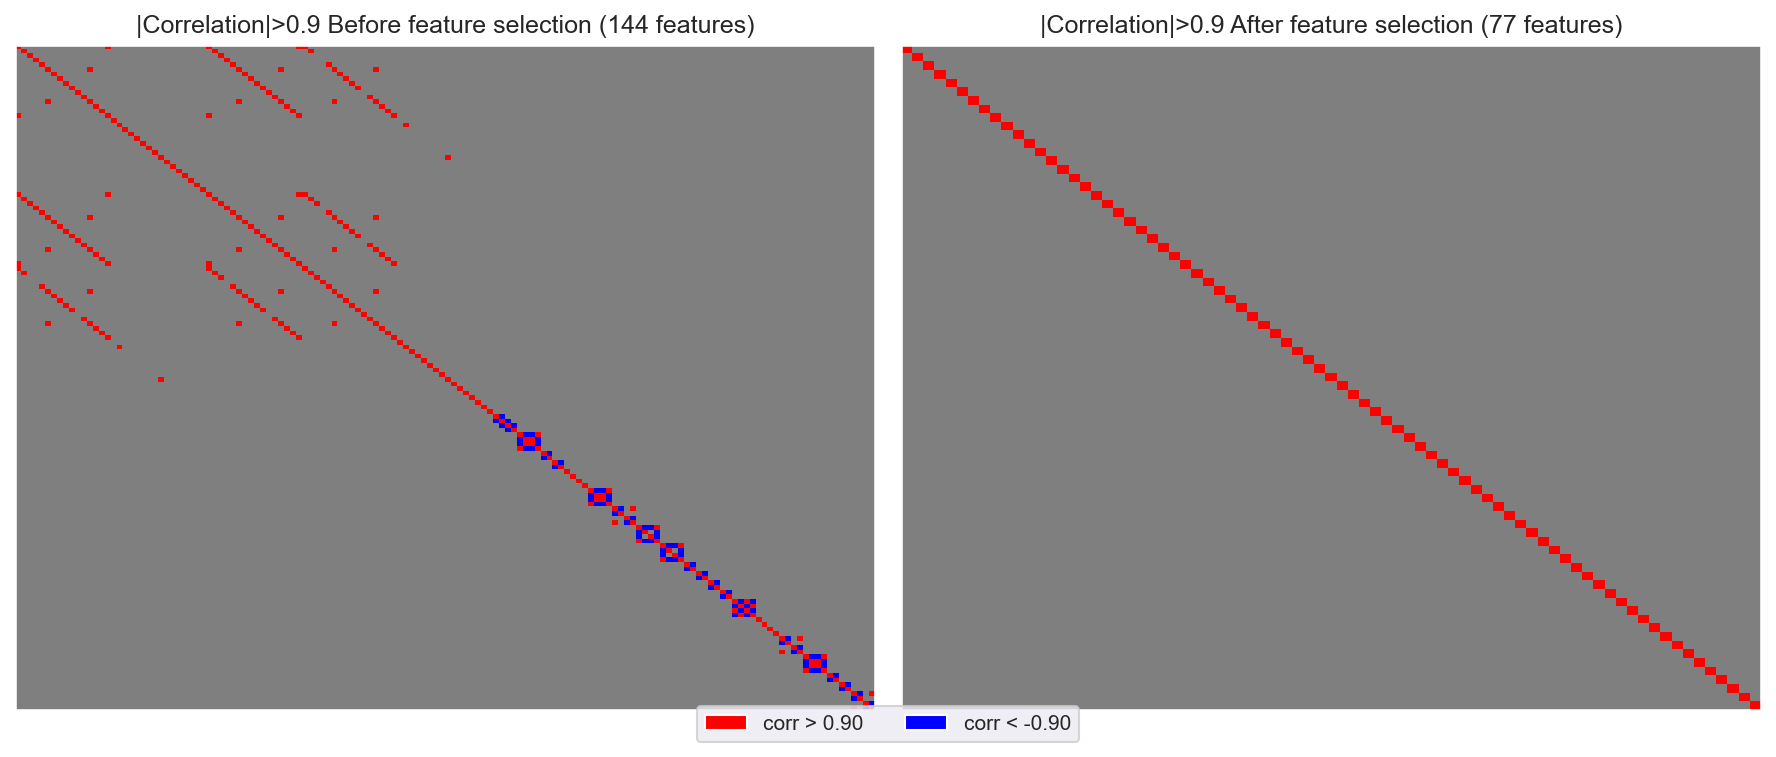

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# thresholds
threshold_upper = 0.90
threshold_lower = -0.90

def make_colored_corr(df):
    corr = df.corr().values
    n = corr.shape[0]
    
    colored = np.zeros((n, n, 3))
    
    for i in range(n):
        for j in range(n):
            val = corr[i, j]
            if val > threshold_upper:
                colored[i, j] = [1, 0, 0]       # red
            elif val < threshold_lower:
                colored[i, j] = [0, 0, 1]       # blue
            else:
                colored[i, j] = [0.5, 0.5, 0.5] # grey
    
    return colored

# Create colored matrices
colored_train = make_colored_corr(df_train)
colored_val   = make_colored_corr(df_train_new)   # or df_test

# ---- Plot two side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

axes[0].imshow(colored_train, aspect='auto')
axes[0].set_title("|Correlation|>0.9 Before feature selection (144 features)", fontsize=12)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(colored_val, aspect='auto')
axes[1].set_title("|Correlation|>0.9 After feature selection (77 features)", fontsize=12)
axes[1].set_xticks([])
axes[1].set_yticks([])

# ---- Add legend ----
legend_elements = [
    Patch(facecolor='red',   label='corr > 0.90'),
    Patch(facecolor='blue',  label='corr < -0.90')
]

fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=3,
           bbox_to_anchor=(0.5, -0.02),
           fontsize=10)


plt.tight_layout()
plt.show()


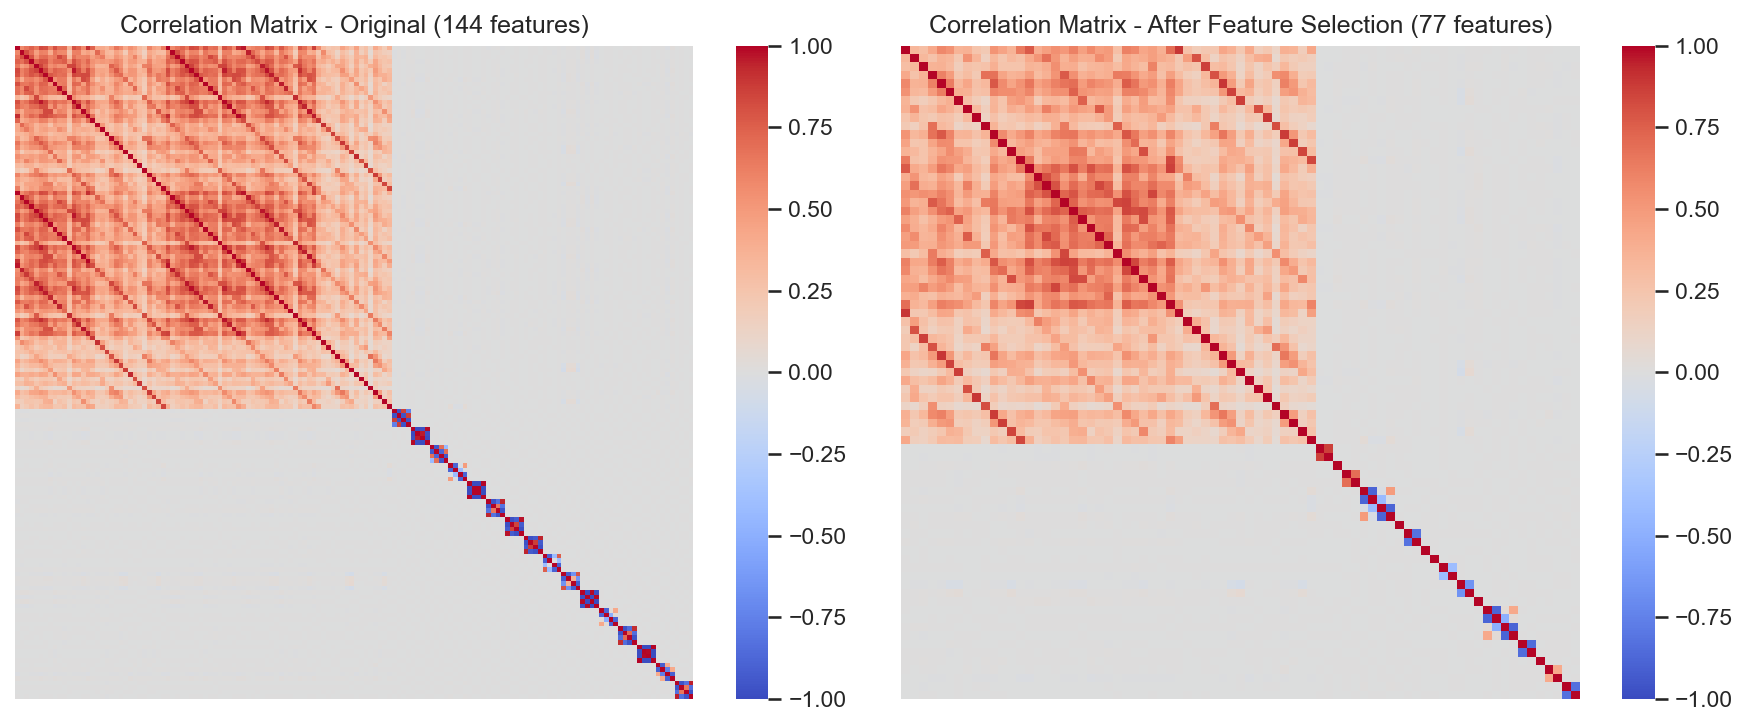

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Create subplots ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# ---- First heatmap (original train) ----
sns.heatmap(
    df_train.corr(),
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    xticklabels=False,
    yticklabels=False,
    linewidths=0,
    linecolor=None,
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix - Original (144 features)", fontsize=12)

# ---- Second heatmap (new train) ----
sns.heatmap(
    df_train_new.corr(),
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    xticklabels=False,
    yticklabels=False,
    linewidths=0,
    linecolor=None,
    ax=axes[1]
)
axes[1].set_title("Correlation Matrix - After Feature Selection (77 features)", fontsize=12)

plt.tight_layout()
plt.show()


# PCA Analysis

In [36]:
# Use PCA for dimensionality reduction

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume X is your dataframe or numpy array with shape (n_samples, 144)
# If it's a dataframe:
# X = your_dataframe.values

X_train_scaled = df_train_new
X_val_scaled = df_val_new
X_test_scaled = df_test_new

# Fit PCA
n_components = 35
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train_scaled)

# Transform using training PCA
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance_ratio)
print("Total variance explained by top 35 components:", explained_variance_ratio.sum())

# Convert to DataFrame for training
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
print(X_pca_df.shape)  # Should be (n_samples, 20)

# Now you can use X_pca_df for training your model


Explained variance by each component: [0.24768326 0.04720653 0.03985995 0.03147403 0.02695824 0.02683977
 0.02591288 0.02520905 0.02492229 0.02422699 0.02399081 0.02377492
 0.02371965 0.02232366 0.02198545 0.02134426 0.01988748 0.01841911
 0.01828201 0.01774684 0.01574548 0.01471704 0.01311988 0.01301793
 0.01299658 0.01299028 0.01298169 0.01295674 0.01266866 0.01178268
 0.01018786 0.0097606  0.00889392 0.00811066 0.00768853]
Total variance explained by top 35 components: 0.9093857099755278
(29971, 35)


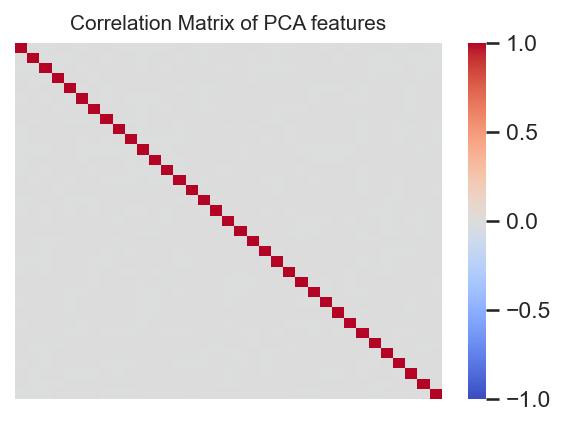

In [37]:
# Compute correlation matrix
corr_matrix = X_pca_df.corr()

plt.figure(figsize=(4,3), dpi=150)  # large figure and high resolution
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    xticklabels=False,  # hide x labels
    yticklabels=False,  # hide y labels
    linewidths=0,       # remove gaps
    linecolor=None       # no lines
)

plt.title("Correlation Matrix of PCA features", fontsize=10)
plt.tight_layout()
plt.show()

In [40]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error

# # Create SVR model
svm_regressor = MultiOutputRegressor(
    make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma="scale", verbose=True))
)

#Fit and predict using the SVM regressor
svm_regressor.fit(X_pca, Labels_train_mean)

[LibSVM]............................................................................................................................................*.............................................................*..*
optimization finished, #iter = 202932
obj = -18083982.766898, rho = -19.897333
nSV = 29422, nBSV = 26283
.........................................................................................................*...........................................*
optimization finished, #iter = 148086
obj = -28786925.075886, rho = -33.896628
nSV = 29609, nBSV = 26814
...................................................................................*.....................................*
optimization finished, #iter = 120559
obj = -42018061.258068, rho = -34.155114
nSV = 29709, nBSV = 27211
....................................................................................*...............................*
optimization finished, #iter = 115431
obj = -37610485.428186, rho = -38.471896

MultiOutputRegressor(estimator=Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=100, verbose=True))]))

In [135]:
# Predict on val set
y_val_pred = svm_regressor.predict(X_val_pca)
# Compute Mean Squared Error
mse_val = mean_squared_error(Labels_val_mean, y_val_pred)
print("Val Set MSE:", mse_val)
r2 = r2_score(Labels_val_mean, y_val_pred)
print("Val Set R^2:", r2)

Val Set MSE: 397.30005623804834
Val Set R^2: 0.5756720369551311


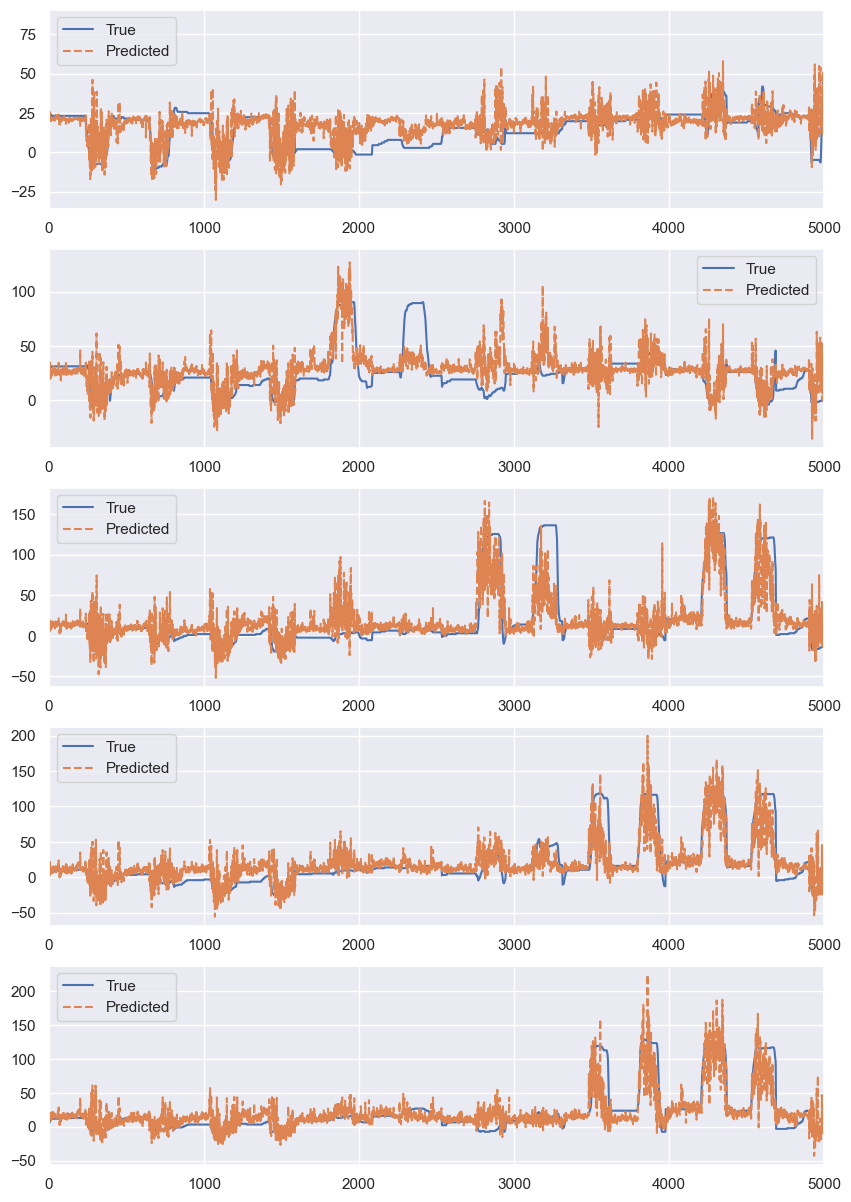

In [130]:
# Plot the true and predicted values for all finger angles - VAL set
fig, ax = plt.subplots(5, 1, figsize=(10, 15))
for i in range(5):
    ax[i].plot(Labels_val_mean[:,i], label="True")
    ax[i].plot(y_val_pred[:,i], linestyle="--", label="Predicted")
    ax[i].set_xlim(0, 5000)
    ax[i].legend()

In [131]:
from sklearn.metrics import mean_squared_error

mse_each = mean_squared_error(Labels_val_mean, y_val_pred, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = mean_squared_error(Labels_val_mean, y_val_pred)
print("Mean MSE:", mse_mean)

MSE per finger: [148.82785229 313.49166161 625.03474132 446.04471957 453.1013064 ]
Mean MSE: 397.30005623804834


In [134]:
from sklearn.metrics import r2_score

r2_each = r2_score(Labels_val_mean, y_val_pred, multioutput='raw_values')
print("R2 per finger:", r2_each)

r2_mean = r2_score(Labels_val_mean, y_val_pred)
print("Mean R2:", r2_mean)

R2 per finger: [0.51261738 0.49042789 0.58676605 0.6392612  0.64928767]
Mean R2: 0.5756720369551311


# Hyperparameter tuning

In [41]:
X_train_scaled = df_train_new
X_val_scaled = df_val_new
X_test_scaled = df_test_new

x_train = X_train_scaled
y_train = Labels_train_mean
x_val = X_val_scaled
y_val = Labels_val_mean

In [42]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((29971, 77), (29971, 5), (7793, 77), (7793, 5))

In [139]:
# 1. Define grid
param_grid = {
    "svr__kernel": ["linear", "rbf"],
    "svr__C": [0.01, 0.1, 1, 10, 100],
    "svr__gamma": ["scale", "auto"]
}

# 2. Generate combinations
grid = list(ParameterGrid(param_grid))
print("Total configurations:", len(grid))

results = []

# 3. Grid search loop (manual, since we use val set)
for i, params in enumerate(grid, 1):

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR())
    ])
    
    # Set parameters
    pipeline.set_params(**params)

    model = MultiOutputRegressor(pipeline, n_jobs=-1)

    # Fit
    model.fit(x_train, y_train)

    # Predict
    y_val_pred = model.predict(x_val)

    # MSE
    mse = mean_squared_error(y_val, y_val_pred)

    results.append((mse, params))
    print(f"[{i}/{len(grid)}] MSE={mse:.6f} | {params}")

# 4. Best result
results_sorted = sorted(results, key=lambda x: x[0])
best_mse, best_params = results_sorted[0]

print("\nBest configuration:")
print("MSE =", best_mse)
print(best_params)


Total configurations: 20
[1/20] MSE=627.302968 | {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x1078ac040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1050d8040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[2/20] MSE=1034.371889 | {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
[3/20] MSE=627.302968 | {'svr__C': 0.01, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}
[4/20] MSE=1034.371889 | {'svr__C': 0.01, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
[5/20] MSE=590.312731 | {'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x105044040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1069bc040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[6/20] MSE=839.679332 | {'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
[7/20] MSE=590.312731 | {'svr__C': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x104944040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[8/20] MSE=839.679332 | {'svr__C': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
[9/20] MSE=590.013233 | {'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
[10/20] MSE=477.983683 | {'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
[11/20] MSE=590.013233 | {'svr__C': 1, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}
[12/20] MSE=477.983683 | {'svr__C': 1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x107728040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1080c4040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[13/20] MSE=590.056134 | {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
[14/20] MSE=334.534805 | {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x10a06c040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102b08040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[15/20] MSE=590.056134 | {'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}
[16/20] MSE=334.534890 | {'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x105740040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104aa0040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

KeyboardInterrupt: 

Optimal -> [18/20] MSE=261.860892 | {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}

# Train final model

In [43]:
# Train the optimal model (final model to be used for inference)

from sklearn.pipeline import make_pipeline

# define model
final_svm_regressor = MultiOutputRegressor(
    make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma="scale", verbose=True))
)

#Fit and predict using the SVM regressor
final_svm_regressor.fit(X_train_scaled, Labels_train_mean)


[LibSVM]................................................................................................................................................................................*..........................................................................*........*
optimization finished, #iter = 257940
obj = -13340676.326599, rho = -20.597312
nSV = 29295, nBSV = 24572
............................................................................................................................................*................................................*
optimization finished, #iter = 188211
obj = -22257381.776431, rho = -35.443507
nSV = 29523, nBSV = 25360
.................................................................................................................*.......................................*
optimization finished, #iter = 152371
obj = -31190730.593107, rho = -35.242799
nSV = 29634, nBSV = 25901
.....................................................................

MultiOutputRegressor(estimator=Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=100, verbose=True))]))

# Predict and evaluate final model

In [46]:
# Validation set inference

print("VALIDATION SET INFERENCE")
# Predict on val set
y_val_pred = final_svm_regressor.predict(X_val_scaled)

mse_each = mean_squared_error(Labels_val_mean, y_val_pred, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = mean_squared_error(Labels_val_mean, y_val_pred)
print("Mean MSE:", mse_mean)

r2_each = r2_score(Labels_val_mean, y_val_pred, multioutput='raw_values')
print("R2 per finger:", r2_each)

r2_mean = r2_score(Labels_val_mean, y_val_pred)
print("Mean R2:", r2_mean)


# Test set inference

print("TEST SET INFERENCE")
# Predict on test set
y_test_pred = final_svm_regressor.predict(X_test_scaled)

mse_each = mean_squared_error(Labels_test_mean, y_test_pred, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = mean_squared_error(Labels_test_mean, y_test_pred)
print("Mean MSE:", mse_mean)

r2_each = r2_score(Labels_test_mean, y_test_pred, multioutput='raw_values')
print("R2 per finger:", r2_each)

r2_mean = r2_score(Labels_test_mean, y_test_pred)
print("Mean R2:", r2_mean)

VALIDATION SET INFERENCE
MSE per finger: [103.71156336 234.57851345 456.01494517 336.34577676 328.60180812]
Mean MSE: 291.850521370824
R2 per finger: [0.66036456 0.61869905 0.69851139 0.72798025 0.74565355]
Mean R2: 0.6902417602791863
TEST SET INFERENCE
MSE per finger: [ 81.14281093 216.61097108 395.65198174 404.31040531 398.23751312]
Mean MSE: 299.1907364356679
R2 per finger: [0.7019737  0.68776077 0.76270644 0.70304193 0.73462648]
Mean R2: 0.7180218630667843


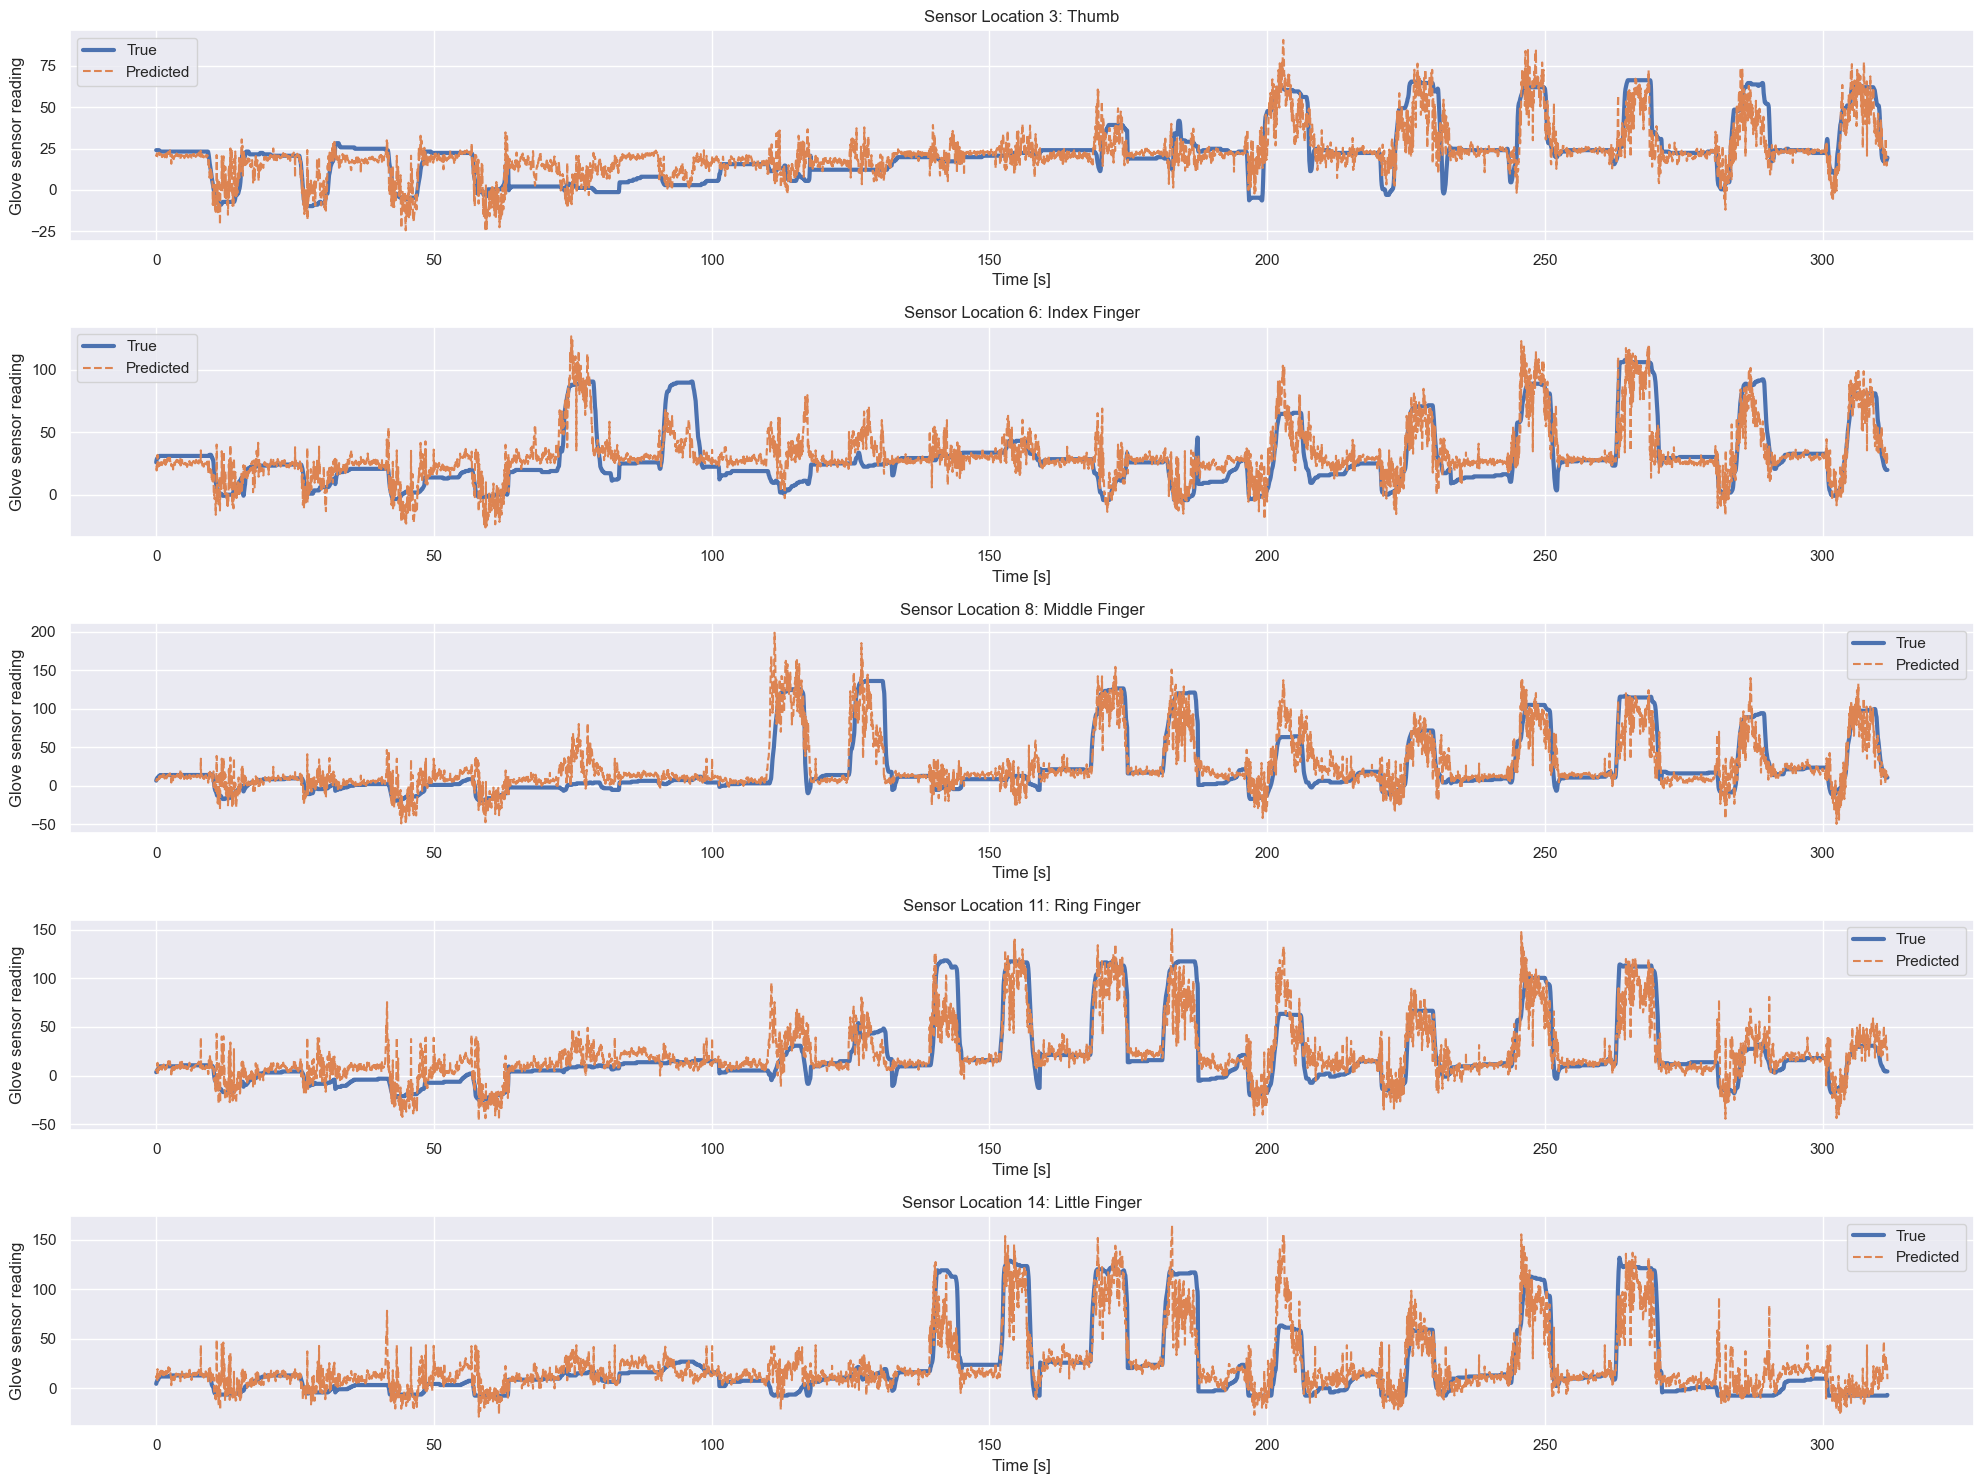

In [52]:
# Visualise Predictions on VAL SET

# Plot the true and predicted values for all finger angles - VAL set
time_axis = np.arange(Labels_val_mean.shape[0]) / 25 # fs = 25Hz, since the glove sensor data was sampled at 25 Hz
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
title_names = ["Sensor Location 3: Thumb", "Sensor Location 6: Index Finger", "Sensor Location 8: Middle Finger", "Sensor Location 11: Ring Finger", "Sensor Location 14: Little Finger"]
for i in range(5):
    ax[i].plot(time_axis, Labels_val_mean[:,i], linewidth=3, label="True")
    ax[i].plot(time_axis, y_val_pred[:,i], linestyle="--", label="Predicted")
    ax[i].set_xlabel("Time [s]")  # set x-axis label
    ax[i].set_ylabel("Glove sensor reading")  # set y-axis label
    ax[i].legend()
    ax[i].set_title(title_names[i]) 

fig.tight_layout()
plt.show()

# Visualise predictions and explain

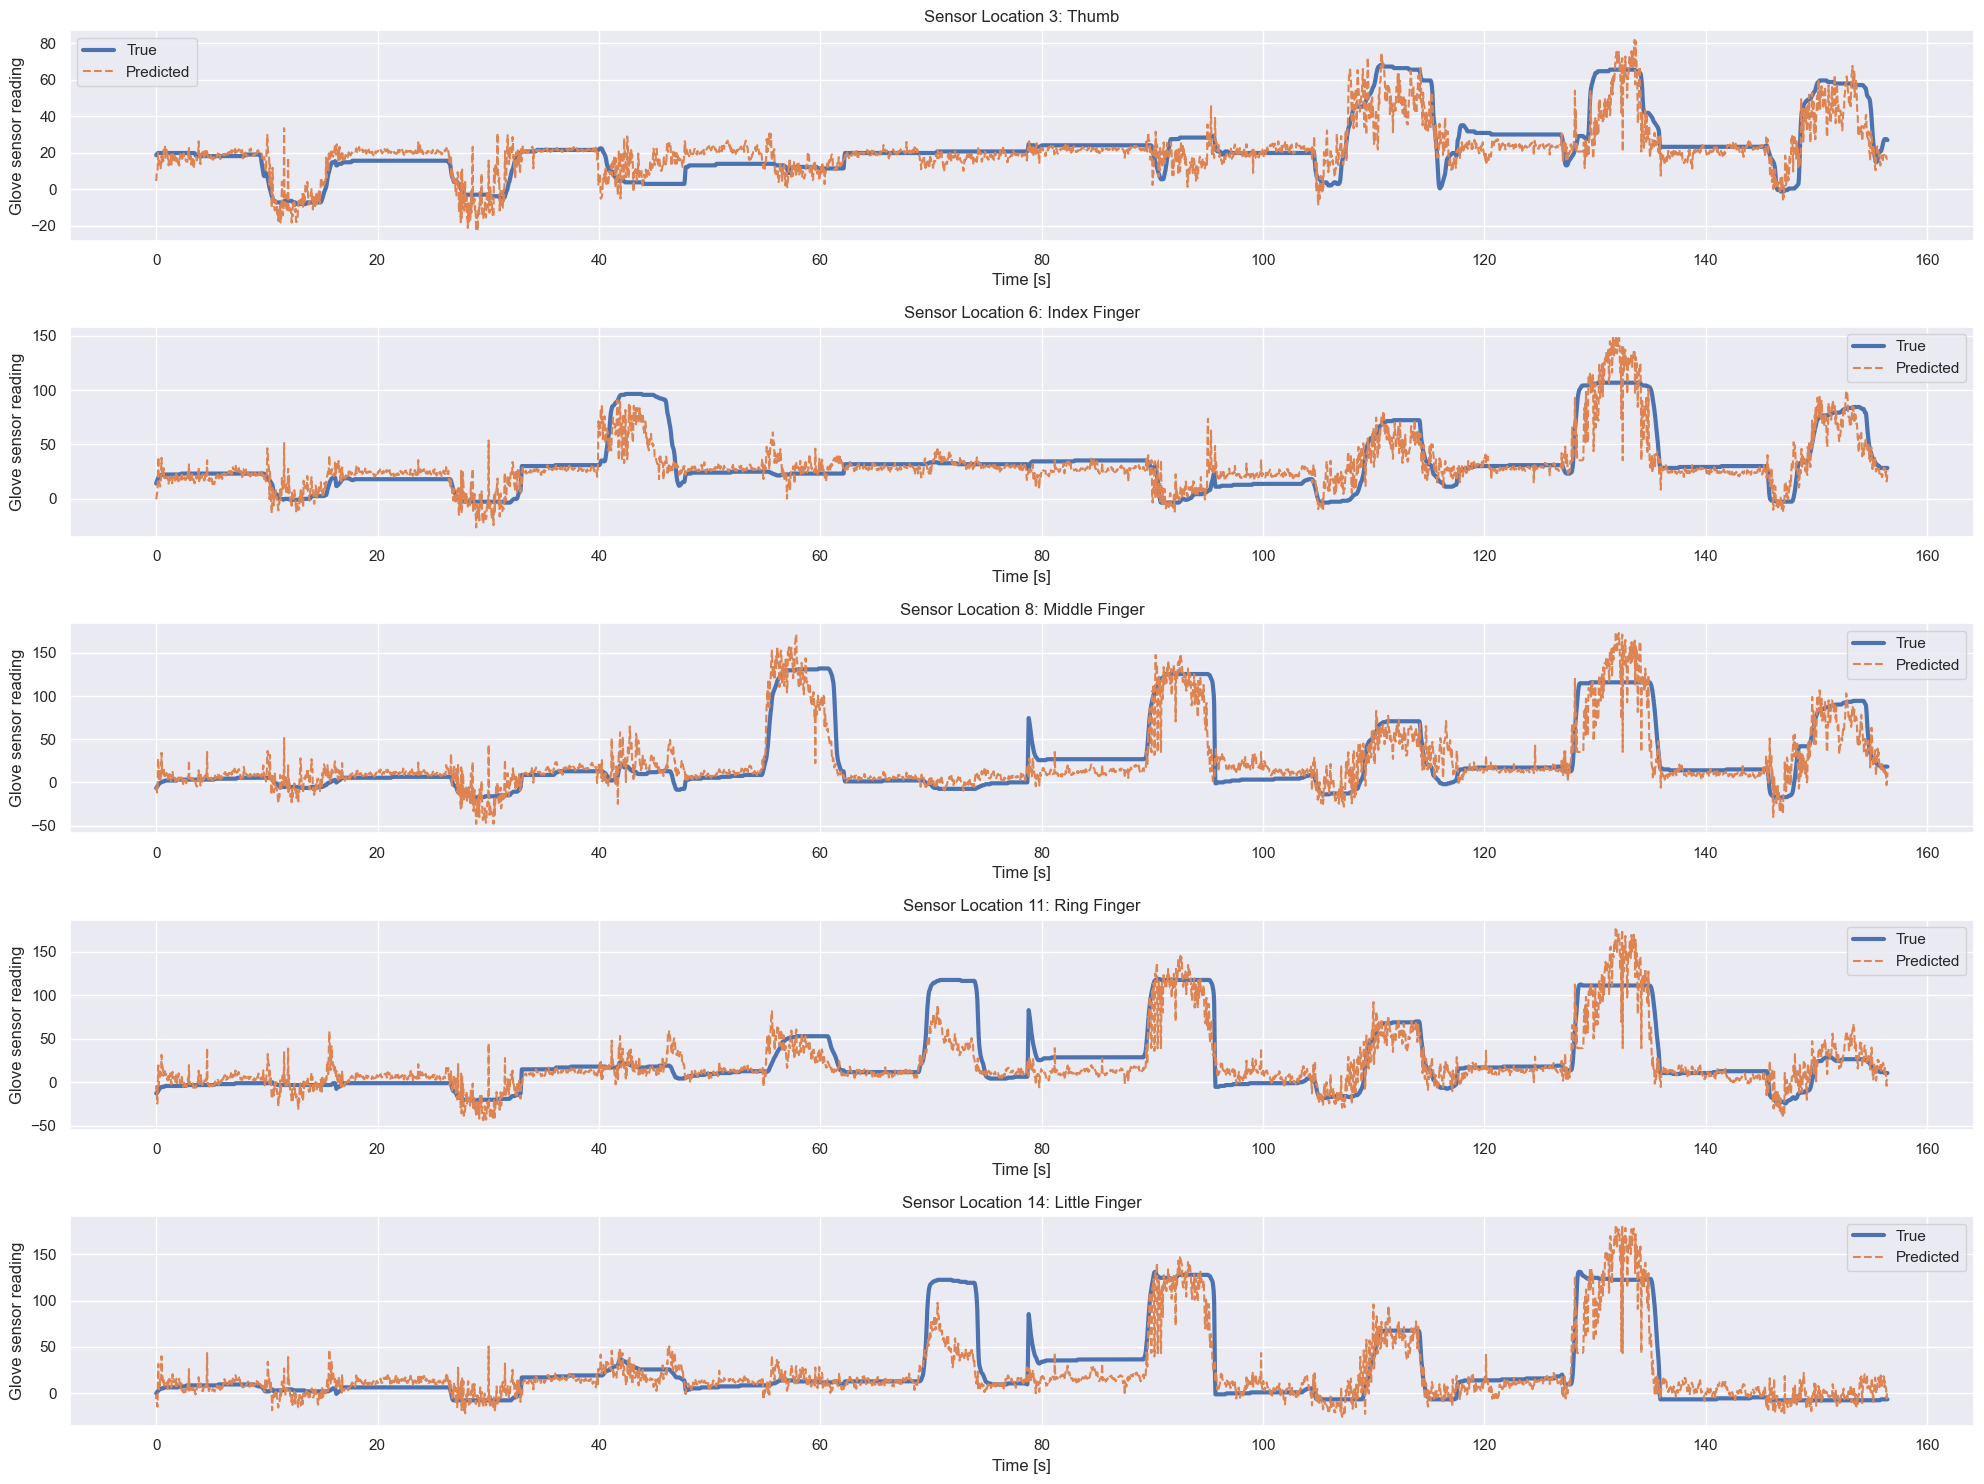

In [53]:
# Visualise Predictions on TEST SET

# Plot the true and predicted values for all finger angles - VAL set
time_axis = np.arange(Labels_test_mean.shape[0]) / 25 # fs = 25Hz, since the glove sensor data was sampled at 25 Hz
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
title_names = ["Sensor Location 3: Thumb", "Sensor Location 6: Index Finger", "Sensor Location 8: Middle Finger", "Sensor Location 11: Ring Finger", "Sensor Location 14: Little Finger"]
for i in range(5):
    ax[i].plot(time_axis, Labels_test_mean[:,i], linewidth=3, label="True")
    ax[i].plot(time_axis, y_test_pred[:,i], linestyle="--", label="Predicted")
    ax[i].set_xlabel("Time [s]")  # set x-axis label
    ax[i].set_ylabel("Glove sensor reading")  # set y-axis label
    ax[i].legend()
    ax[i].set_title(title_names[i]) 
    
    #ax[i].set_xlim(0, 5000)


fig.tight_layout()
fig.savefig("predictions_test.png", dpi=300) 
plt.show()

In [50]:
for i in range(5):
    print("MSE - ", title_names[i], end=": ") 
    # var_y = np.var(Labels_test_mean)
    # r2 = 1 - mean_squared_error(Labels_test_mean[:,i], y_test_pred[:,i]) / var_y
    print(mean_squared_error(Labels_test_mean[:,i], y_test_pred[:,i]))

MSE -  Sensor Location 3: Thumb: 81.14281092811551
MSE -  Sensor Location 6: Index Finger: 216.61097108357237
MSE -  Sensor Location 8: Middle Finger: 395.65198173584594
MSE -  Sensor Location 11: Ring Finger: 404.3104053059661
MSE -  Sensor Location 14: Little Finger: 398.23751312484063


In [51]:
for i in range(5):
    print("R2 - ", title_names[i], end=": ") 
    # var_y = np.var(Labels_test_mean)
    # r2 = 1 - mean_squared_error(Labels_test_mean[:,i], y_test_pred[:,i]) / var_y
    print(r2_score(Labels_test_mean[:,i], y_test_pred[:,i]))

R2 -  Sensor Location 3: Thumb: 0.7019736973645101
R2 -  Sensor Location 6: Index Finger: 0.687760769210878
R2 -  Sensor Location 8: Middle Finger: 0.7627064374718908
R2 -  Sensor Location 11: Ring Finger: 0.7030419335189215
R2 -  Sensor Location 14: Little Finger: 0.7346264777677122


We use the R2 scores for comparison. Middle finger and the little finger have maximum R2. The ring finger and thumb have almost similar R2. The thumb has the minimum R2. 

* The paper "Effect of User Practice on Prosthetic Finger Control With an Intuitive Myoelectric Decode" tell us that decoding accuracy is strongly influenced by signal clarity and selective muscle activation. Middle finger flexion generates large, reliable EMG patterns, which predicts kinematics with high accuracy.
* The middle finger is one of the more independent digits, as it has a dedicated tendon compartment. The paper mentions that more independent muscle activity gives better decoding performance, due to a cleaner mapping.
* The little finger is next because it is somewhat independent. There is less overlap with central FDP/FDS compartments.
* The ring finger is the most coupled finger biomechanically, as it shares tendon slips with both middle and little fingers (muscle 'co-activation'). So it might generate mixed EMG patterns due to interdigit coupling.
* Thumb motion depends heavily on intrinsic hand muscles which do not lie in the forearm, where sEMG electrodes are placed. Thus, forearm EMG could not capture the signal accurately. The extrinsic thumb-moving muscles overlap heavily with wrist muscles, causing large crosstalk, thus the decoding model receives poorly separated features.

Our findings complement the findings significantly, which are - "The highest average decoding accuracy was achieved for the ring/little fingers DOA (median 0.73, range 0.41) followed by the middle finger DOA (median 0.71, range 0.24). The worst performance was observed for the thumb flexion DOA (median 0.44, range 0.45)."